In [1]:
import sys
sys.path.append('3W')
sys.path.append('BibMon')

In [2]:
import os
import copy
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import missingno

In [3]:
tags = {'P-PDG':'Pa', 
        'P-TPT':'Pa', 'T-TPT':'degC',
         'P-MON-CKP':'Pa', 'T-JUS-CKP':'degC', 
         'P-JUS-CKGL':'Pa', 
         # 'T-JUS-CKGL':'degC',
         'QGL': 'sm^3/s'}

names = ['Pressure at the PDG',
         'Pressure at the TPT',
         'Temperature at the TPT',
         'Pressure upstream of the PCK',
         'Temperature downstream of the PCK',
         'Pressure downstream of the GLCK',
         # 'Temperature downstream of the GLCK',
         'Gas lift flow rate']

reference_table = pd.DataFrame(index=np.arange(1,len(names)+1))
reference_table.index.name='Number'
reference_table['Tag'] = tags.keys()
reference_table['Name'] = names
reference_table['Unit'] = tags.values()
reference_table

,Tag,Name,Unit
Number,,,
1,P-PDG,Pressure at the PDG,Pa
2,P-TPT,Pressure at the TPT,Pa
3,T-TPT,Temperature at the TPT,degC
4,P-MON-CKP,Pressure upstream of the PCK,Pa
5,T-JUS-CKP,Temperature downstream of the PCK,degC
6,P-JUS-CKGL,Pressure downstream of the GLCK,Pa
7,QGL,Gas lift flow rate,sm^3/s


In [4]:
plt.rc('font', family='serif', size=12) # controls default text sizes
plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=13)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=14)  # fontsize of the figure title

In [5]:
import bibmon
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
EVENT = 0

PATH = os.path.join('..', '..', '..', '3W', 'dataset', str(EVENT))

# Inicializar a lista de arquivos
files = []

if os.path.exists(PATH):
    files = [f for f in os.listdir(PATH) if os.path.isfile(os.path.join(PATH, f))]
else:
    print(f"O caminho {PATH} não existe.")

dfs = {}

if files:  # Verifica se a lista de arquivos não está vazia
    for file in files:
        file_path = os.path.join(PATH, file)
        try:
            if file.endswith('.csv'):
                # Tentar ler o arquivo CSV com a codificação padrão
                dfs[file[:-4]] = pd.read_csv(file_path, index_col=0, parse_dates=True).rename_axis(None)
            elif file.endswith('.parquet'):
                # Ler o arquivo Parquet
                dfs[file[:-8]] = pd.read_parquet(file_path)  # Remover o sufixo '.parquet'
            else:
                print(f"Formato de arquivo desconhecido para {file}.")
        except Exception as e:
            print(f"Erro ao ler {file}: {e}")

    print('Data read!\nNumber of instances: ', len(dfs))
else:
    print("Nenhum arquivo encontrado.")



Data read!
Number of instances:  594


{'WELL-00001_20170201010207':                      ABER-CKGL  ABER-CKP  ESTADO-DHSV  ESTADO-M1  ESTADO-M2  \
timestamp                                                                     
2017-02-01 01:02:07        NaN       NaN          1.0        1.0        0.0   
2017-02-01 01:02:08        NaN       NaN          1.0        1.0        0.0   
2017-02-01 01:02:09        NaN       NaN          1.0        1.0        0.0   
2017-02-01 01:02:10        NaN       NaN          1.0        1.0        0.0   
2017-02-01 01:02:11        NaN       NaN          1.0        1.0        0.0   
...                        ...       ...          ...        ...        ...   
2017-02-01 06:59:56        NaN       NaN          1.0        1.0        0.0   
2017-02-01 06:59:57        NaN       NaN          1.0        1.0        0.0   
2017-02-01 06:59:58        NaN       NaN          1.0        1.0        0.0   
2017-02-01 06:59:59        NaN       NaN          1.0        1.0        0.0   
2017-02-01 07:00:00   

In [7]:
def plot_timeseries_well(ax, well):
    start_index = index_beginnings_new_period[well][0]

    if well < 8:
        end_index1 = index_beginnings_new_period[well + 1][0]
    else:
        end_index1 = None  # Alcançamos o último poço

    end_index2 = 597 if well >= 8 else end_index1

    # Combina os dados dentro do intervalo
    data = pd.concat([dfs[key] for key in instance_beginnings[start_index:end_index1]]).drop_duplicates()
    data_raw = data.filter(items=tags.keys())
    # print(data)
    data = data_raw.apply(pd.to_numeric, errors='coerce')

    # tags_nans = data.columns[data.isna().any()].tolist()
    # tags_nans
    
    # print('Quantity, by tag, of strings being changed to NaN:\n')
    
    # for tag in tags_nans:
    #     print(tag, 
    #           data_raw[tag].loc[data_raw[tag][data[tag].isnull()].index].unique().tolist(),
    #           data[tag].isnull().sum())
    
    # Loop para plotar cada série de dados (coluna)
    for i in range(7):
        
        # Filtra e imprime valores diferentes de 0, 1 e NaN
        # filtered_values = data.iloc[:, i][(data.iloc[:, i].values != 0) & 
        #                                    (data.iloc[:, i].values != 1) & 
        #                                    (~data.iloc[:, i].isna())]

    
        ax[i].plot(data.iloc[:, i].values, c='k', linewidth=0.8)

        # Adiciona linhas verticais para marcar eventos no intervalo
        for j in range(start_index, end_index2):
            loc = data.index.get_loc(dfs[instance_beginnings[j]].index[0])
            if isinstance(loc, (list, np.ndarray)):
                loc = np.argmax(loc)  # Pegue o índice do primeiro True
            else:
                # Caso contrário, use o valor como está
                loc = loc

            ax[i].axvline(loc, ls='--', linewidth=0.6)

        # Linhas verticais em vermelho para marcações importantes
        for j in index_beginnings_new_period[well]:
            loc = data.index.get_loc(dfs[instance_beginnings[j]].index[0])
            if isinstance(loc, (list, np.ndarray)):
                loc = np.argmax(loc)  # Pegue o índice do primeiro True
            else:
                # Caso contrário, use o valor como está
                loc = loc
            ax[i].axvline(loc, c='r', linewidth=2)

        ax[i].set_ylabel(i + 1, rotation=0, fontsize=14)
        ax[i].set_yticks([])

        # Limpar bordas desnecessárias
        ax[i].spines["top"].set_visible(False)
        ax[i].spines["right"].set_visible(False)
        ax[i].spines["left"].set_visible(False)

        if i < 7:  # Oculta os eixos X de todos, exceto o último gráfico
            ax[i].set_xticks([])
            ax[i].spines["bottom"].set_visible(False)
            ax[i].xaxis.set_ticks_position('none')
        else:
            # Rotaciona rótulos no último gráfico para melhor legibilidade
            for label in ax[i].get_xticklabels():
                label.set_rotation(45)
                label.set_ha('right')

    return data


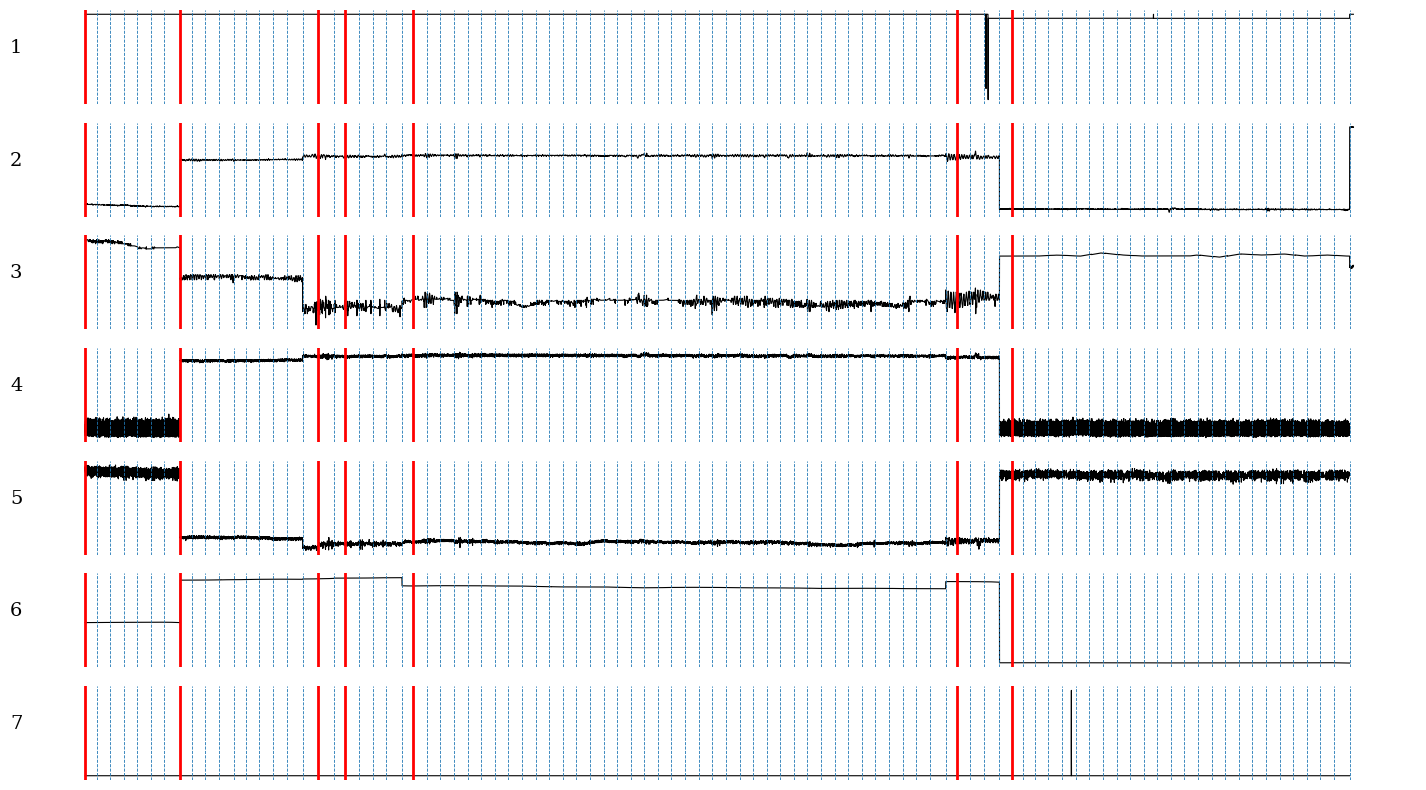

In [20]:
instance_beginnings = sorted(dfs.keys())

index_beginnings_new_period = {1: [0,7,17,19,24,64,68], 
                               2: [94,99,102,153,169,183,261],
                               3: [304,308,309,318,322],
                               4: [330],
                               5: [342,361,368,411,417],
                               6: [423,439,453,473],
                               # 7: [538],
                               8: [540,561,579,594]}#final: 596

fig, ax = plt.subplots(7, 1, figsize=(18, 10),sharex=True)

# data_well1 = plot_timeseries_well (ax = ax,  well = 1)
data_well2 = plot_timeseries_well (ax = ax,  well = 1)


In [9]:
first_tag = list(tags.keys())[0]
print(first_tag)  # Saída: 'P-PDG'

for j in index_beginnings_new_period[1]:
    loc = data_well1.index.get_loc(dfs[instance_beginnings[j]].index[0])
    print(dfs[instance_beginnings[j]].index[0])
    
data_well1.index = pd.to_datetime(data_well1.index)
is_monotonic_increasing = data_well1.index.is_monotonic_increasing
print("Is the index monotonic increasing?", is_monotonic_increasing)
if not is_monotonic_increasing:
    data_well1 = data_well1.sort_index()

data_well2.index = pd.to_datetime(data_well2.index)
is_monotonic_increasing = data_well2.index.is_monotonic_increasing
print("Is the index monotonic increasing?", is_monotonic_increasing)
if not is_monotonic_increasing:
    data_well2 = data_well2.sort_index()


# # print(data_well1.index)
# print(data_well1.loc['2017-02-01 01:02:07':'2017-02-18 00:01:46'])


P-PDG
2017-02-01 01:02:07
2017-02-18 00:01:46
2017-04-22 03:00:00
2017-04-24 22:01:56
2017-05-20 23:00:00
2017-06-26 14:01:23
2017-08-23 09:21:46
Is the index monotonic increasing? False
Is the index monotonic increasing? False


In [10]:
# (X_train, X_validation, 
#  X_test, Y_train, 
#  Y_validation, Y_test) = bibmon.train_val_test_split(data_well1, 
#                                                      start_train = '2017-02-01 01:02:07', 
#                                                      end_train = '2017-04-24 22:01:56', 
#                                                      end_validation = '2017-05-20 23:00:00', 
#                                                      end_test = '2017-06-26 14:01:23',
#                                                      tags_Y = 'P-PDG')

In [11]:
# from sklearn.ensemble import RandomForestRegressor  
# reg = RandomForestRegressor(n_jobs=-1, random_state=1)

# model = bibmon.sklearnRegressor(reg) 

In [12]:
# from sklearn.metrics import r2_score
# from sklearn.metrics import mean_absolute_error

# mtr = [r2_score, mean_absolute_error]

In [13]:
# print(Y_train)

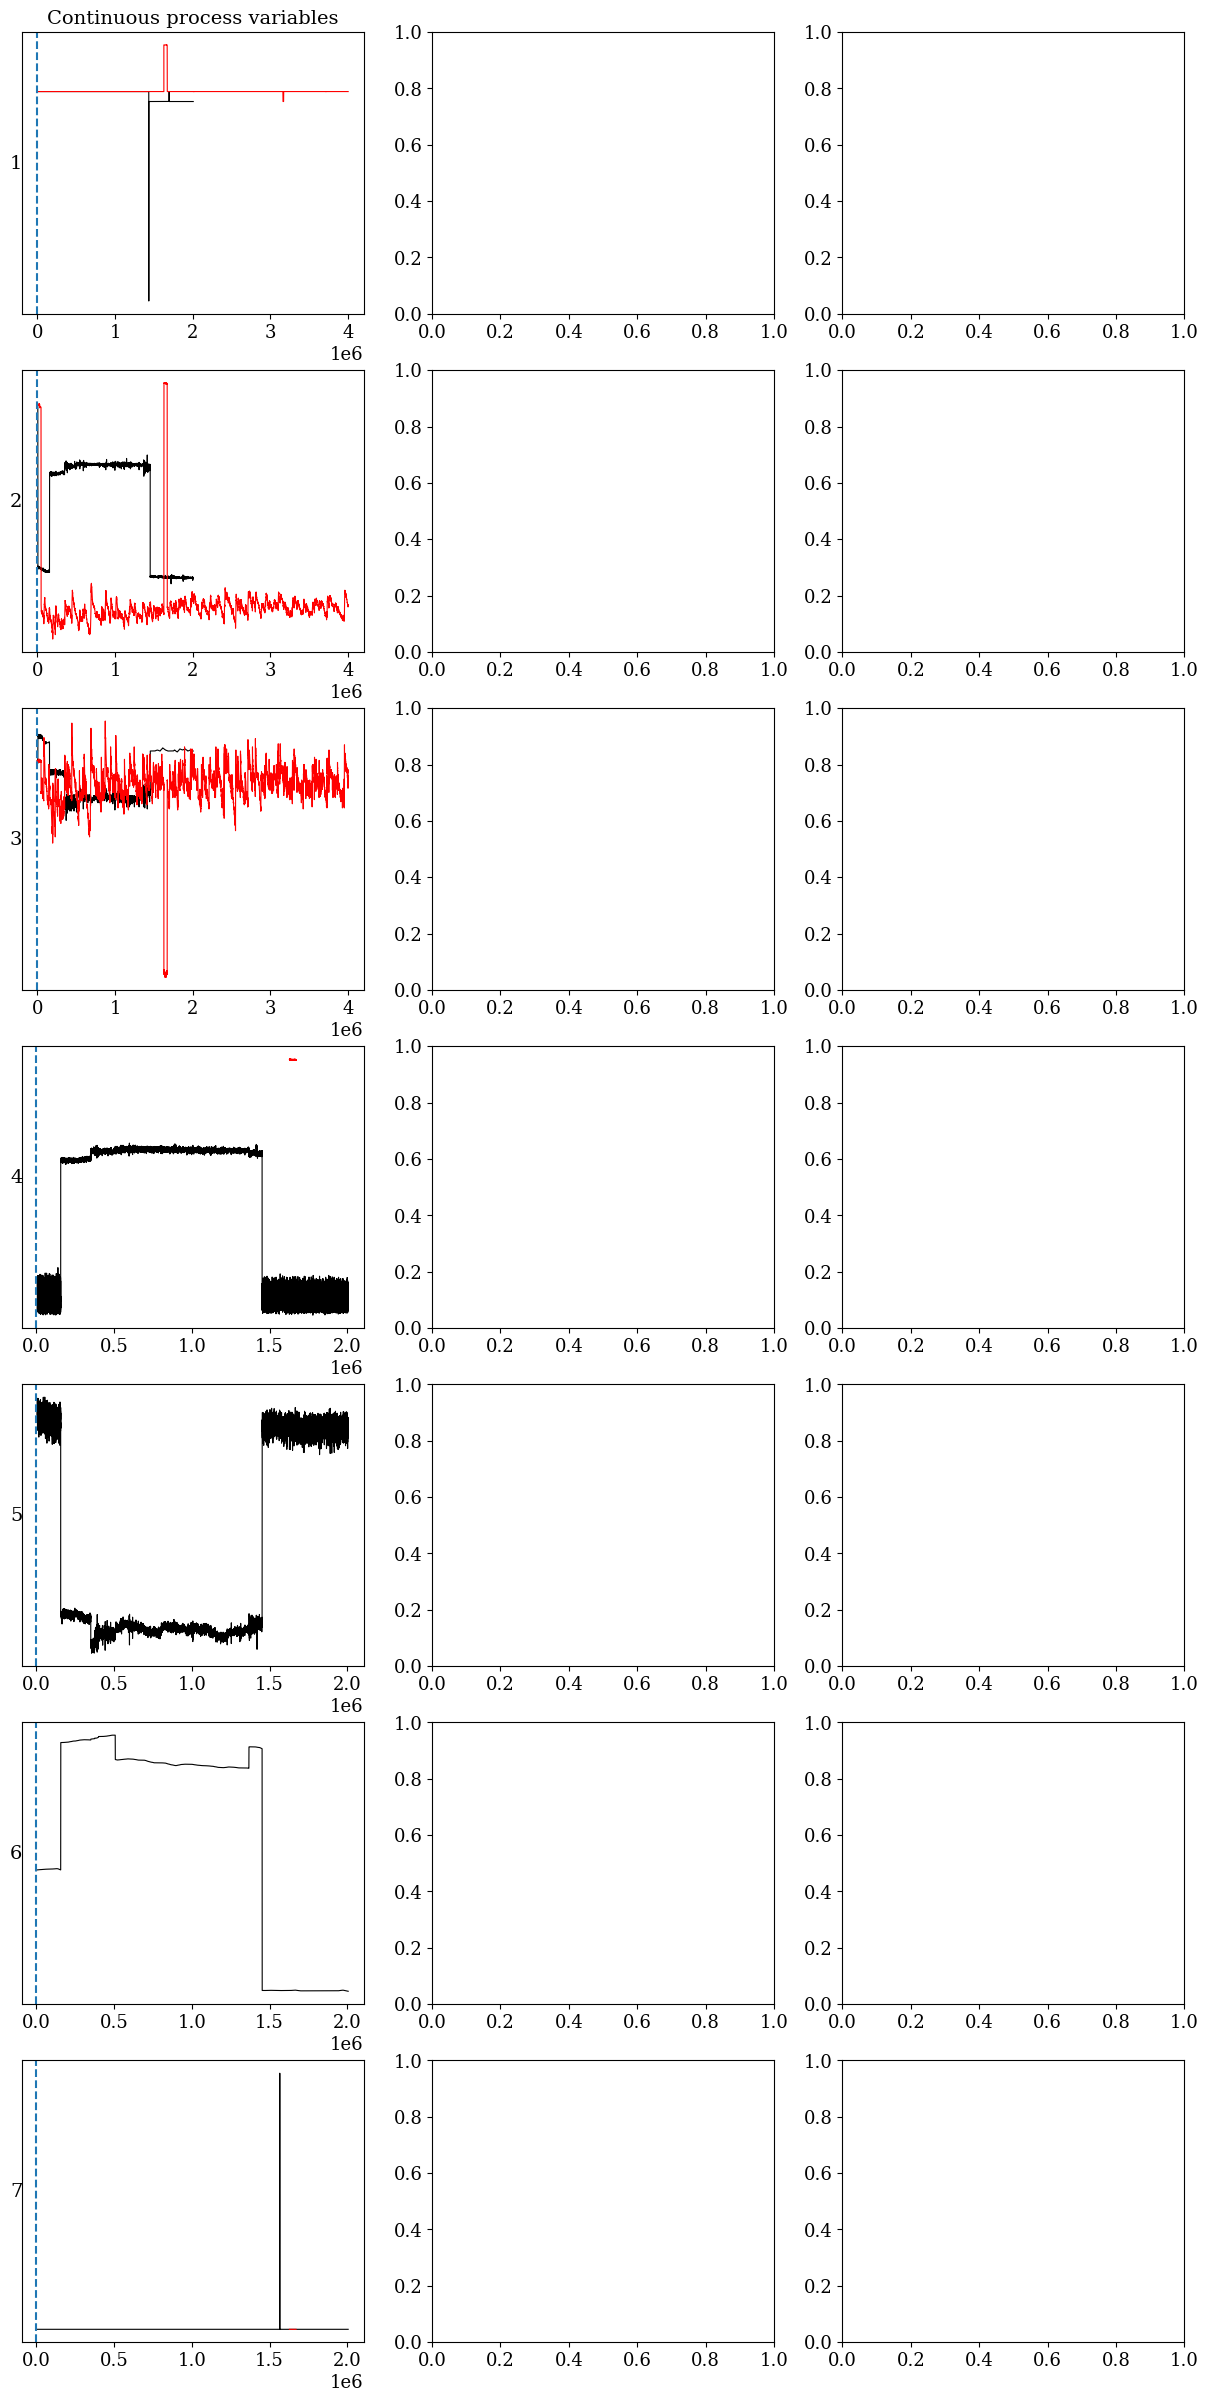

In [14]:
def plot_tep_fault(df_train, df_test):
            
    fig, ax = plt.subplots(7, 3, figsize=(15, 30))

    for i in range(7):
        ax[i,0].plot(df_train.iloc[:,i].values,c='k',linewidth=0.8)
        ax[i,0].plot(df_test.iloc[:,i].values,c='r',linewidth=0.8)
        ax[i,0].axvline(160, ls='--')
        ax[i,0].set_yticks([])
        ax[i,0].set_ylabel(i+1,rotation=0,fontsize=14)
        # for j in range(3):
        #     ax[i,j].spines["top"].set_visible(False)
        #     ax[i,j].spines["right"].set_visible(False)
        #     ax[i,j].spines["left"].set_visible(False)
        # if i<(22-1):
        #     ax[i,0].set_xticks([])
        #     ax[i,0].spines["bottom"].set_visible(False)

    # for i in range(19):
    #     ax[i,1].plot(df_train.iloc[:,i+22].values,c='k',linewidth=0.8)
    #     ax[i,1].plot(df_test.iloc[:,i+22].values,c='r',linewidth=0.8)
    #     ax[i,1].axvline(160, ls='--')
    #     ax[i,1].set_yticks([])
    #     ax[i,1].set_ylabel(i+23,rotation=0,fontsize=14)
    #     if i!=(19-1):
    #         ax[i,1].set_xticks([])
    #         ax[i,1].spines["bottom"].set_visible(False)

    # for i in range(11):
    #     ax[i,2].plot(df_train.iloc[:,i+41].values,c='k',linewidth=0.8)
    #     ax[i,2].plot(df_test.iloc[:,i+41].values,c='r',linewidth=0.8)
    #     ax[i,2].axvline(160, ls='--')
    #     ax[i,2].set_yticks([])
    #     ax[i,2].set_ylabel(i+42,rotation=0,fontsize=14)
    #     if i!=(11-1):
    #         ax[i,2].set_xticks([])
    #         ax[i,2].spines["bottom"].set_visible(False)

    # for i in range(19,22):
    #     ax[i,1].axis('off')

    # for i in range(11,22):
    #     ax[i,2].axis('off')

    ax[0,0].set_title('Continuous process variables',fontsize=14)
    # ax[0,1].set_title('Sampled composition variables',fontsize=14)
    # ax[0,2].set_title('Continuous manipulated variables',fontsize=14);

plot_tep_fault(data_well1, data_well2)                